In [24]:
from sklearn.model_selection import RepeatedKFold

In [20]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [16]:
RANDOM_STATE=42

# Loading Datasets

y_test is the same for all datasets

In [79]:
y_test = np.load("y_test_bow.npy")

In [80]:
print(y_test.shape)

(45,)


Transcript BOW

In [9]:
X_train_bow = np.load("X_train_bow.npy")
X_test_bow = np.load("X_test_bow.npy")
y_train_bow = np.load("y_train_bow.npy")

Mean word2vec

In [10]:
X_train_w = np.load("X_train_mean_w2v.npy")
X_test_w = np.load("X_test_mean_w2v.npy")
y_train_w = np.load("y_train_mean_w2v.npy")

Doc2vec

In [11]:
X_train_d = np.load("X_train_doc2vec.npy")
X_test_d = np.load("X_test_doc2vec.npy")
y_train_d = np.load("y_train_doc2vec.npy")

Tfidf

In [12]:
X_train_tf = np.load("X_train_tfidf.npy")
X_test_tf = np.load("X_test_tfidf.npy")
y_train_tf = np.load("y_train_tfidf.npy")

Gaze features

In [13]:
# f0
X_train_g0 = np.load("X_train_g0.npy")
X_test_g0 = np.load("X_test_g0.npy")
y_train_g0 = np.load("y_train_g0.npy")
# f1
X_train_g1 = np.load("X_train_g1.npy")
X_test_g1 = np.load("X_test_g1.npy")
y_train_g1 = np.load("y_train_g1.npy")
# fh0
X_train_gh0 = np.load("X_train_gh0.npy")
X_test_gh0 = np.load("X_test_gh0.npy")
y_train_gh0 = np.load("y_train_gh0.npy")
# fh1
X_train_gh1 = np.load("X_train_gh1.npy")
X_test_gh1 = np.load("X_test_gh1.npy")
y_train_gh1 = np.load("y_train_gh1.npy")
# f01
X_train_g01 = np.load("X_train_g01.npy")
X_test_g01 = np.load("X_test_g01.npy")
y_train_g01 = np.load("y_train_g01.npy")
# fh0h1
X_train_gh0h1 = np.load("X_train_gh0h1.npy")
X_test_gh0h1 = np.load("X_test_gh0h1.npy")
y_train_gh0h1 = np.load("y_train_gh0h1.npy")

# Evaluation

In [60]:
def evaluate_on_training_set(y_test, y_pred):
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

# Custom Ensemble

In [252]:
class Ensemble:
    def __init__(self):
        self.clf = []
        self.X_train = []
        self.X_test = []
        self.y_train = []
        self.y_test = None
        
    def set_clf(self, ls_clf):
        self.clf = ls_clf
    
    def set_train_test(self, ls_train, ls_test, y_train, y_test):
        self.X_train = ls_train
        self.X_test = ls_test
        self.y_train = y_train
        self.y_test = y_test
        
    def train_ens(self):
        for i in range(len(self.clf)):
            c_i = self.clf[i]
            X_train_i = self.X_train[i]
            y_train_i = self.y_train[i]
            c_i.fit(X_train_i, y_train_i)
            self.clf[i] = c_i
    
    def pred_proba(self, ls_X):
        probas = []
        for i in range(len(self.clf)):
            c_i = self.clf[i]
            probas.append(c_i.predict_proba(ls_X[i]))
        probas = np.array(probas)
        probas = np.mean(probas, axis=0)
        return probas
    
    def pred_ens(self, ls_X):
        print(ls_X[0].shape)
        probas = self.pred_proba(ls_X)
        label = np.argmax(probas)
        return label
    
    def evaluate_ens(self):
        predictions = []       
        for i in range(len(self.y_test)):
            ls_X = []
            for j in range(len(self.clf)):
                ls_X.append(self.X_test[j][i:i+1][:])
            predictions.append(self.pred_ens(ls_X))
        predictions = np.array(predictions)
        print(predictions)
        print(self.y_test)
        
        evaluate_on_training_set(self.y_test, predictions)
        
    def ens_kcross(self, k=10, n=1, random_state=RANDOM_STATE):
        f1_scores = []
        recall_scores = []
        rkf = RepeatedKFold(n_splits=k, n_repeats=n, random_state=RANDOM_STATE)
        
        X_train_ls = []
        X_val_ls = []
        y_train_ls = []
        y_val_ls = []
        
        for i in range(len(self.clf)): # need to do this because the X_train sizes are different in each dataset ### WELL IT DOESNT WORK WELL PLAYED @ MYSELF
            X_train_temp = []
            X_val_temp = []
            y_train_temp = []
            y_val_temp = []
            
            X = self.X_train[i]
            y = self.y_train[i]
            
            for train_index, val_index in rkf.split(X):

                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]
                X_train_temp.append(X_train)
                X_val_temp.append(X_val)
                y_train_temp.append(y_train)
                y_val_temp.append(y_val)
                
            X_train_ls.append(np.array(X_train_temp))
            X_val_ls.append(np.array(X_val_temp))
            y_train_ls.append(np.array(y_train_temp))
            y_val_ls.append(np.array(y_val_temp))

        for j in range(k):
            for i in range(len(self.clf)):
                model = self.clf[i]
                
                X_train = X_train_ls[i][j]
                y_train = y_train_ls[i][j]
                X_val = X_val_ls[i][j]
                y_val = y_val_ls[i][j]
                

                model.fit(X_train, y_train) 
                
                
            predictions = []       
            for i in range(len(y_val)):
                ls_X = []
                for j in range(len(self.clf)):
                    ls_X.append(np.array([X_val[i]]))

                pred = self.pred_ens(ls_X)
                predictions.append(pred)
            predictions = np.array(predictions)

            f1 = f1_score(y_val, predictions)
            f1_scores.append(f1)
            recall = recall_score(y_val, predictions)
            recall_scores.append(recall)

        return f1_scores, recall_scores
    
        

In [253]:
# Set the models with best parameters
clf_bow = LogisticRegression(C=1000000, n_jobs=3)
clf_w = LogisticRegression(C=1000000, n_jobs=3)
clf_d = SVC(C= 1, degree = 4, kernel ='poly', probability=True)
clf_tf = MultinomialNB(0.5)
# clf_gh1 = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=1)
clfs = [clf_bow, clf_w, clf_d, clf_tf]

X_train_ls = [X_train_bow, X_train_w, X_train_d, X_train_tf]
X_test_ls = [X_test_bow, X_test_w, X_test_d, X_test_tf]
y_train_ls = [y_train_bow, y_train_w, y_train_d, y_train_tf]

C:\Users\65842\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass alpha=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [254]:
e = Ensemble()
e.set_clf(clfs)
e.set_train_test(X_train_ls, X_test_ls, y_train_ls, y_test)

In [255]:
f1_scores, recall_scores = e.ens_kcross()
print("F1 score: {}, Recall score: {}".format(np.mean(f1_scores), np.mean(recall_scores)))

C:\Users\65842\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\65842\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\65842\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarra

(1, 10000)


ValueError: X has 10000 features per sample; expecting 2902

In [ ]:
e.train_ens()

[0 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1
 1 1 0 0 1 1 1 1]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.6993087557603687
              precision    recall  f1-score   support

           0       0.86      0.61      0.72        31
           1       0.48      0.79      0.59        14

    accuracy                           0.67        45
   macro avg       0.67      0.70      0.66        45
weighted avg       0.74      0.67      0.68        45

Confusion Matrix: 
 [[19 12]
 [ 3 11]]


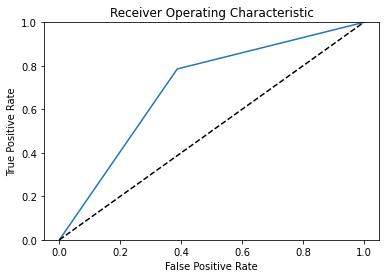

In [116]:
e.evaluate_ens()